In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import colors
import cv2

***Show the Image***

In [2]:
def show_image_plt(img_bgr):
    rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb)
    plt.show()

def show_image(img):
    cv2.imshow("Image", img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

***height (rows), width(cols)***

In [3]:
def resize_image(vegi):
    height, width, c = vegi.shape
    new_height = 100
    ratio = new_height / height 
    new_width = int(width * ratio)
    dimensions = (new_width, new_height)
    print(dimensions)
    resized_img = cv2.resize(vegi, dimensions, interpolation=cv2.INTER_LINEAR)
    print("New shape:      ", resized_img.shape)

    return resized_img

# current values for borders they roughly fit to the real hsv values. I test it for brown onion, carrot, brown potato with
# white background, respectively
def mask_image(img_hsv, img_rgb, border_low=(8, 50, 75), border_high=(15, 255, 160)):
    #15, 23, 135
    mask = cv2.inRange(img_hsv, border_low, border_high)
    result = cv2.bitwise_and(img_rgb, img_rgb, mask=mask)

    #plt.subplot(1, 3, 1)
    #plt.imshow(img_rgb)
    #plt.subplot(1, 3, 2)
    #plt.imshow(mask, cmap='gray')
    #plt.subplot(1, 3, 3)
    #plt.imshow(result)
    #plt.show()
    return mask, result
    

def resize_to_square(vegi_bgr):
    img_size = 256
    height, width = vegi_bgr.shape[:2]
    a1 = width / height
    a2 = height / width

    if (a1 > a2):
        r_img = cv2.resize(vegi_bgr, (round(img_size * a1), img_size), interpolation = cv2.INTER_AREA)
        margin = int(r_img.shape[1]/6)
        resized_img = r_img[0:img_size, margin:(margin+img_size)]

    elif(a1 < a2):
        # if height greater than width
        r_img = cv2.resize(vegi_bgr, (img_size, round(img_size * a2)), interpolation = cv2.INTER_AREA)
        margin = int(r_img.shape[0]/6)
        resized_img = r_img[margin:(margin+img_size), 0:img_size]

    elif(a1 == a2):
        # if height and width are equal
        r_img = cv2.resize(vegi_bgr, (img_size, round(img_size * a2)), interpolation = cv2.INTER_AREA)
        resized_img = r_img[0:img_size, 0:img_size]

    if(resized_img.shape[0] != img_size or resized_img.shape[1] != img_size):
        resized_img = r_img[0:img_size, 0:img_size]

    return resized_img


def flip_image_and_show(img):
    # flip vertical
    img_v = cv2.flip(img, 0)
    #show_image_plt(onion_sq_v)

    #flip horizontal
    img_h = cv2.flip(img, 1)
    #show_image_plt(onion_sq_h)

    #flip vertical + horizontal
    img_vh = cv2.flip(img, -1)
    #show_image_plt(onion_sq_vh)

    fig, axarr = plt.subplots(2, 2) #1 row, 3 cols
    fig.tight_layout(h_pad=4)
    axarr[0][0].imshow(img)
    axarr[0][0].set_title("Original")
    axarr[0][1].imshow(img_v)
    axarr[0][1].set_title("Flip Vertical")
    axarr[1][0].imshow(img_h)
    axarr[1][0].set_title("Flip Horizontal")
    axarr[1][1].imshow(img_vh)
    axarr[1][1].set_title("Flip Vertical + Horizontal")
    fig.suptitle('Flipped Images')
    plt.subplots_adjust(top = 0.85)


def rotate_image_and_show(img):
    # rotate 90 degree clockwise
    img_r90 = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    #show_image_plt(onion_sq_v)

    #rotate 180 degree
    img_r180 = cv2.rotate(img, cv2.ROTATE_180)
    #show_image_plt(onion_sq_h)

    #rotate 90 degree counterclockwise
    img_rcw90 = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    #show_image_plt(onion_sq_vh)

    fig, axarr = plt.subplots(2, 2) #2 row, 2 cols
    fig.tight_layout(h_pad=4)

    axarr[0][0].imshow(img)
    axarr[0][0].set_title("Original")
    axarr[0][1].imshow(img_r90)
    axarr[0][1].set_title("+ 90")
    axarr[1][0].imshow(img_r180)
    axarr[1][0].set_title("+ 180")
    axarr[1][1].imshow(img_rcw90)
    axarr[1][1].set_title("- 90")

    fig.suptitle('Rotated Images')
    plt.subplots_adjust(top = 0.85)


def draw_bounding_box(img, low_threshold, high_threshold):
    # the thresholds are used as gradients thresholds. 
    # Something like, gradients smaller than the low_threshold or between the thresholds are ignored 
    result = img.copy()
    gray_square_onion = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    thresh = cv2.threshold(gray_square_onion, low_threshold, high_threshold, cv2.THRESH_BINARY)[1]

    # get contours
    contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    for cntr in contours:
        x,y,w,h = cv2.boundingRect(cntr)
        # The idea is only keep bigger bounding boxes. Probably it presents the object
        if w > 22 and h > 0.5:
            cv2.rectangle(result, (x, y), (x+w, y+h), (100, 0, 255), 1)
            ROI = img[y:y+h, x:x+w]
            print(f"ROI:. Size of Bounding Box: w = {w} / h = {h}")
        else:
            continue
    show_image_plt(result)


def plot_color_space_rgb_to_hsv(img_rgb, convert_to_hsv=True):
    copy_rgb = img_rgb.copy()
    img_hsv = copy_rgb
    x_label = "R (X)"
    y_label = "G (Y)"
    z_label = "B (Z)"

    if convert_to_hsv:
        img_hsv = cv2.cvtColor(copy_rgb, cv2.COLOR_RGB2HSV)
        x_label = "Hue X"
        y_label = "Saturation Y"
        z_label = "Value Z"

    pixel_colors = copy_rgb.reshape((np.shape(copy_rgb)[0]*np.shape(copy_rgb)[1], 3))
    norm = colors.Normalize(vmin=-1.,vmax=1.)
    norm.autoscale(pixel_colors)
    pixel_colors = norm(pixel_colors).tolist()

    x, y, z = cv2.split(img_hsv)
    fig = plt.figure()
    axis = fig.add_subplot(1, 1, 1, projection="3d")

    axis.scatter(x.flatten(), y.flatten(), z.flatten(), facecolors=pixel_colors, marker=".")
    axis.set_xlabel(x_label)
    axis.set_ylabel(y_label)
    axis.set_zlabel(z_label)
    plt.show()


def print_color_values(img):
    for row in range(0, img.shape[1]):
        for col in range(0, img.shape[1]):
            print(f"Row {row}: Spalte {col} {img[row, col]}")

def kMeans_(img_rgb, number_of_clusters, attempts):
    # KMeans Processing
    img_hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
    K = number_of_clusters
    onion_2D = img_hsv.reshape((-1,3)) #Reshape to 2 dimensional image (65536, 3)
    onion_2D = np.float32(onion_2D)

    CONSTANT_1 = 10
    CONSTANT_2 = 1.0
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, CONSTANT_1, CONSTANT_2)

    ret, label, center=cv2.kmeans(onion_2D, K, None, criteria, attempts, cv2.KMEANS_PP_CENTERS)
    center = np.uint8(center)
    res = center[label.flatten()]
    result_image = res.reshape((img_rgb.shape))

    return result_image, label, center

#Expect gray img
def min_area_rect(img_rgb, low_thresh, high_thresh):
    # Convert the image to grayscale
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
    #gray = img_rgb.copy()
    #gray = cv2.blur(gray, (3,3))

    #plt.imshow(gray, cmap='gray')
    #plt.show()

    # Use Otsu's method to calculate a dynamic threshold
    #a, thresh = cv2.threshold(gray, low_thresh, high_thresh, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    #print(thresh.min(), thresh.max())
    #thresh_low = 0.5 * thresh
    #thresh_high = 1.5 * thresh
    # Apply edge detection using the dynamic threshold
    edges = cv2.Canny(gray, low_thresh, high_thresh)
    
    # Find contours in the edged image
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    print('Length Contours: ', len(contours))
    # Find the contour with the maximum area
    max_contour = max(contours, key=cv2.contourArea)
    #print(contours)
    # Get the rotated bounding box of the contour
    rect = cv2.minAreaRect(max_contour)
    box = cv2.boxPoints(rect)
    box = np.intp(box)
    
    # Draw the rotated bounding box on the original image
    result_image = img_rgb.copy()
    cv2.drawContours(result_image, [box], 0, (0, 255, 0), 2)
    thres = 10
    return result_image, thres, box

def get_object_color(center, cluster_img_hsv):
    for point in center:
        edge_point = 0
        if (point == cluster_img_hsv[0][0]).all():
            edge_point += 1

        if (point == cluster_img_hsv[0][255]).all():
            edge_point += 1

        if (point == cluster_img_hsv[255][255]).all():
            edge_point += 1

        if (point == cluster_img_hsv[255][0]).all():
            edge_point += 1

        if edge_point >= 3:
            #print(f"Color Background found: {point}")
            pass

        if edge_point < 3:
            #print(f"Color Object found: {point}")
            return point

https://realpython.com/python-opencv-color-spaces/

The Code below is for data augmentation. It is a technique for enlarging a dataset.
It will use the standard techniques like horizontal & vertical flipping and rotation.

Load Images from personal cloud storage

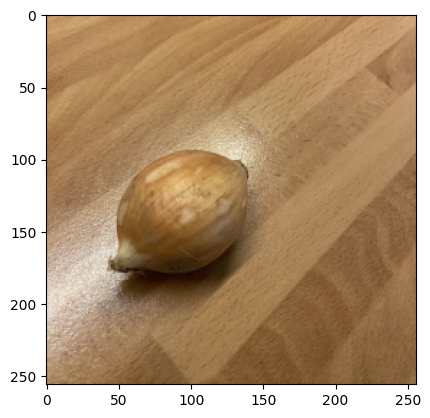

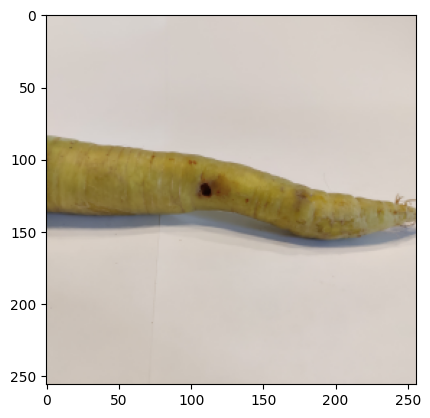

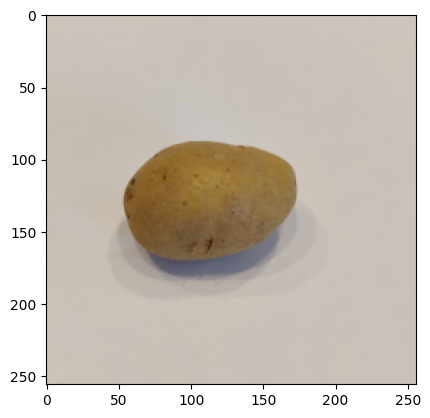

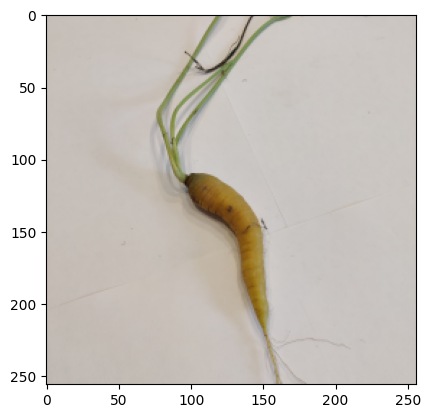

In [4]:
path = "G:\Meine Ablage\Images_AI_Project\zwiebel_jpg\zwiebel_1.jpg"
onion = cv2.imread(path.replace("\\","/"))
#onion = cv2.cvtColor(onion, cv2.COLOR_BGR2RGB)

path = "G:\Meine Ablage\KI_Projekt\Bilder\Karotte\karotte_107.jpg"
carrot = cv2.imread(path.replace("\\","/"))
#carrot = cv2.cvtColor(carrot, cv2.COLOR_BGR2RGB)

path = "G:\Meine Ablage\KI_Projekt\Bilder\Karotte_Trieb\karotte_trieb_67.jpg"
carrot_trieb = cv2.imread(path.replace("\\","/"))
#carrot_trieb = cv2.cvtColor(carrot_trieb, cv2.COLOR_BGR2RGB)

path = "G:\Meine Ablage\Images_AI_Project\kartoffel_jpg\kartoffel_122.jpg"
potato = cv2.imread(path.replace("\\","/"))
#potato = cv2.cvtColor(potato, cv2.COLOR_BGR2RGB)

onion_sq = resize_to_square(onion)
carrot_sq = resize_to_square(carrot)
potato_sq = resize_to_square(potato)
carrot_trieb_sq = resize_to_square(carrot_trieb)

show_image_plt(onion_sq)
show_image_plt(carrot_sq)
show_image_plt(potato_sq)
show_image_plt(carrot_trieb_sq)

Applying the median filter https://theailearner.com/tag/cv2-medianblur/

https://machinelearningknowledge.ai/image-segmentation-in-python-opencv/

In [5]:
def kMeans_for_rgb_img(img_rgb, number_of_clusters, attempts):
    # KMeans Processing
    #img_hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
    K = number_of_clusters
    onion_2D = img_rgb.reshape((-1,3)) #Reshape to 2 dimensional image (65536, 3)
    onion_2D = np.float32(onion_2D)

    CONSTANT_1 = 10
    CONSTANT_2 = 1.0
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, CONSTANT_1, CONSTANT_2)

    ret, label, center=cv2.kmeans(onion_2D, K, None, criteria, attempts, cv2.KMEANS_PP_CENTERS)
    center = np.uint8(center)
    res = center[label.flatten()]
    result_image = res.reshape((img_rgb.shape))

    return result_image, label, center

def mask_image_rgb(img_rgb, border_low=(8, 50, 75), border_high=(15, 255, 160)):
    #15, 23, 135
    mask = cv2.inRange(img_rgb, border_low, border_high)
    result = cv2.bitwise_and(img_rgb, img_rgb, mask=mask)

    plt.subplot(1, 3, 1)
    plt.imshow(img_rgb)
    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.subplot(1, 3, 3)
    plt.imshow(result)
    plt.show()
    return mask, result


In [6]:
def run_kmeans_old(orig_img):
    median_rgb = cv2.medianBlur(orig_img, 9)
    show_image_plt(median_rgb)

    #gaussian_onion = cv2.GaussianBlur(onion_sq,(5,5),0)
    #show_image_plt(gaussian_onion)

    clusterd_img_hsv, label, center = kMeans(median_rgb, number_of_clusters=2, attempts=100)
    plt.imshow(clusterd_img_hsv)
    plt.show()

    return center, clusterd_img_hsv, median_rgb

def run_bounding_box(clusterd_img_hsv, median_rgb, center_object, t_low, t_high):
    masked_img_gray, masked_img_rgb = mask_image(clusterd_img_hsv, median_rgb, border_low=center_object, border_high=center_object) #borders for hsv colorspace
    #print(masked_img_gray)
    result_image, thresh, box = min_area_rect(masked_img_rgb, t_low, t_high)

    plt.imshow(result_image)
    plt.show()

https://docs.opencv.org/4.x/de/d62/tutorial_bounding_rotated_ellipses.html

Approach: https://stackoverflow.com/questions/72100376/opencv-how-to-draw-a-rotated-bounding-box-in-python

compute dynamically thresholds: https://stackoverflow.com/questions/24862374/canny-edge-detector-threshold-values-gives-different-result

In [7]:
#path = "G:\Meine Ablage\KI_Projekt\Bilder\Zwiebel\zwiebel_9.jpg"
#vegi = cv2.imread(path.replace("\\","/")) # As BGR

def draw_contours(bgr_img, object_area=500):
    #gray = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2GRAY)
    hsv = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2HSV)

    hue, saturation, value = cv2.split(hsv)
    
    blurred_sat = cv2.GaussianBlur(saturation, (7, 7), 0)
    #show_image_plt(blurred_sat)
    # Thresh 50 - 100
    # Or from 85 - 100 removes some more small edges
    # Thresh from 120 only shows the edge from vegi: karotte_107.jpg"
    # Compute the thresh dynamically from the mean() value. 
    thresh = blurred_sat.mean()
    # *****
    std = blurred_sat.std()
    thresh_low = thresh - std
    thresh_high = thresh + std
    # The factors were simply selected by testing the algoritm. Another approach could be to calculate the mean with the standard deviation -> Test it ???
    #thresh_low = 0.3 * thresh 
    #thresh_high = 2 * thresh
    
    #print(f"Thresh low: {thresh_low} and Thresh high: {thresh_high}")
    # The next four lines control how good the bounding box will fit
    edges = cv2.Canny(blurred_sat, thresh_low, thresh_high)
    #show_image_plt(edges)
    kernel = np.ones((4, 4), np.uint8) # creates 4x4 Identity matrix

    # To see the effect if changing kernel and iterations plot it. It seems if the value is to small than the probabillity is higher that the edge lines are not closed
    dilate = cv2.dilate(edges, kernel, iterations=4) 
    #show_image_plt(dilate)

    erode = cv2.erode(dilate, kernel, iterations=4)
    #show_image_plt(erode)
    #print("SHAPE: ", erode.shape)
    contours, hierarchy = cv2.findContours(erode, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10] # ???
   
    bgr_img_copy = bgr_img.copy()
    # Flag makes sure that there is a maximum of 1 box in each image. Assumption, the bounding box for the vegi is always the biggest
    more_than_one_box = False
    for i, contour in enumerate(contours):
        
        area = cv2.contourArea(contour)
        if area >= object_area:
            rect = cv2.minAreaRect(contour)
            box = cv2.boxPoints(rect)
            box = np.intp(box)
            cv2.drawContours(bgr_img_copy, [box], 0, (0, 255, 0), 2)
            
            # Ellipse
            ellipse = cv2.fitEllipse(contour)
            cv2.ellipse(bgr_img_copy, ellipse, (255, 255, 0), 2, cv2.LINE_AA)

            perimeter = cv2.arcLength(contour, True)
            circularity = (4 * np.pi * area) / (perimeter ** 2)
            #print(f"Perimeter: {perimeter}  /// Circularity: {circularity}")
            #print("Draw Contour")
            if i > 0:
                # There are more than 2 boxes in the image
                more_than_one_box = True
    
    rgb = cv2.cvtColor(bgr_img_copy, cv2.COLOR_BGR2RGB)
    
    return rgb, more_than_one_box, box, rect

def get_size_box(box):
    x0 = box[0][0]
    y0 = box[0][1]
    x1 = box[1][0]
    y1 = box[1][1]

    x2 = box[2][0]
    y2 = box[2][1]

    l0_1 = round(((x0 - x1)**2 + (y0 - y1)**2)**0.5, 2)
    l1_2 = round(((x1 - x2)**2 + (y1 - y2)**2)**0.5, 2)

    w = min(l0_1, l1_2)
    h = max(l0_1, l1_2)

    return h, w

def crop_minAreaRect(img_BGR, rect, h, w):
    pic = img_BGR.copy()
    # rotate img
    angle = rect[2]
    rows,cols = img_BGR.shape[0], img_BGR.shape[1]
    M = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1)
    img_rot = cv2.warpAffine(img_BGR,M,(cols,rows))
    #show_image_plt(img_rot)
    
    # rotate bounding box
    rect0 = (rect[0], rect[1], 0.0) 
    box = cv2.boxPoints(rect0)
    box = np.intp(box)
    #print("BOX:", box)
    cv2.drawContours(img_rot, [box], 0, (255, 255, 255), 1) # white frame
    #show_image_plt(img_rot)
    #pts = np.int0(cv2.transform(np.array([box]), M))[0]    
    #pts[pts < 0] = 0
    #print("TRANSFORMED BOX: ", pts)
    w_rect = int(rect[1][0])
    h_rect = int(rect[1][1])
    print(f"IN CROP from rect**: width: {w_rect} hight {h_rect}")
    # crop
    box = np.clip(box, a_min=0, a_max=None)
    #print(box)
    img_crop_BGR = img_rot[box[1][1]:box[1][1]+h_rect, box[1][0]:box[1][0]+w_rect]

    #img_crop = img_rot[pts[1][1]:pts[0][1], 
    #                   pts[1][0]:pts[2][0]]#

    return img_crop_BGR

def is_box_rotated(box):
    # If the box is not rotated then the top left corner should be the first element in box array
    x0, y0 = box[0][0], box[0][1]
    y1 = box[1][1]
    x3 = box[3][0]
    
    if y0 == y1 and x0 == x3:
        # box is not rotated
        return False
    print("BOX IS ROTATED")
    return True

def get_color(rgb_segment):
    cropped_vegi_2D = rgb_segment.reshape((-1,3))
    # convert to np.float32
    cropped_vegi_2D = np.float32(cropped_vegi_2D)

    # define criteria and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1)
    ret,label,center=cv2.kmeans(cropped_vegi_2D, 2, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    # Now separate the data, Note the flatten()
    A = cropped_vegi_2D[label.ravel()==0]
    B = cropped_vegi_2D[label.ravel()==1]

    # Plot the data
    #plt.scatter(A[:,0],A[:,1])
    #plt.scatter(B[:,0],B[:,1],c = 'r')
    #plt.scatter(center[:,0],center[:,1],s = 80,c = 'y', marker = 's')
    #plt.xlabel('Height'),plt.ylabel('Weight')
    #plt.show()

    center = np.uint8(center)
    #print("CENTERS: ", center)
    res = center[label.flatten()]
    res2 = res.reshape((rgb_segment.shape))
    
    #returns center in rgb format
    return center

def mask_green(cropped_vegi_seg_rgb, lower_thresh=(30, 175, 25), higher_thresh=(100, 255, 255)):
    ## Convert to HSV
    cropped_vegi_seg_hsv = cv2.cvtColor(cropped_vegi_seg_rgb, cv2.COLOR_RGB2HSV)

    ## Mask of green (36,25,25) ~ (86, 255,255)
    # mask = cv2.inRange(hsv, (36, 25, 25), (86, 255,255))
    mask = cv2.inRange(cropped_vegi_seg_hsv, lower_thresh, higher_thresh)

    #plt.imshow(mask, cmap='gray')
    #plt.show()
    
    ## Slice the green
    imask = mask>0
    green_rgb = np.zeros_like(cropped_vegi_seg_rgb, np.uint8)
    green_rgb[imask] = cropped_vegi_seg_rgb[imask]

    return green_rgb, imask

    #Image as BGR
def segment_img_2(cropped_vegi_bgr):
    #img must be BGR
    gray = cv2.cvtColor(cropped_vegi_bgr, cv2.COLOR_BGR2GRAY)

    ret, thresh = cv2.threshold(gray, 0, 255,cv2.THRESH_BINARY_INV +cv2.THRESH_OTSU)

    kernel = np.ones((3, 3), np.uint8)
    closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE,kernel, iterations = 15)
    bg = cv2.dilate(closing, kernel, iterations = 1)
    dist_transform = cv2.distanceTransform(closing, cv2.DIST_L2, 0)
    ret, fg = cv2.threshold(dist_transform, 0.02*dist_transform.max(), 255, 0)
    """
    plt.figure(figsize=(10,10))
    
    plt.subplot(2,2,1)
    plt.axis('off')
    plt.title("Original Image")
    plt.imshow(cropped_vegi, cmap="gray")

    plt.subplot(2,2,2)
    plt.imshow(gray, cmap="gray")
    plt.axis('off')
    plt.title("GrayScale Image")
    
    plt.subplot(2,2,3)
    plt.imshow(thresh, cmap="gray")
    plt.axis('off')
    plt.title("Threshold Image")

    plt.subplot(2,2,4)
    plt.imshow(fg, cmap="gray")
    plt.axis('off')
    plt.title("Segmented Image")

    plt.show()
    """
    return thresh

def color_from_segmented_binary(seg_bin, cropped_vegi_bgr):
    imask = seg_bin>0 #False / True array
    segment = np.zeros_like(cropped_vegi_bgr, np.uint8)
    segment[imask] = cropped_vegi_bgr[imask] #BGR

    segment_rgb = cv2.cvtColor(segment, cv2.COLOR_BGR2RGB) #RGB

    return segment_rgb

def keep_object_remove_green(mask, cropped_vegi_seg_rgb):
    inverted_mask = np.invert(mask)
    inverted_green_rgb = np.zeros_like(cropped_vegi_seg_rgb, np.uint8)
    inverted_green_rgb[inverted_mask] = cropped_vegi_seg_rgb[inverted_mask]
    
    return inverted_green_rgb
      

###################Could not draw Bounding Box, because contour area was to small. Exact error: local variable 'box' referenced before assignment
###################Could not draw Bounding Box, because contour area was to small. Exact error: local variable 'box' referenced before assignment
Height: 127. width: 120
BOX IS ROTATED
IN CROP from rect**: width: 120 hight 126
Binary


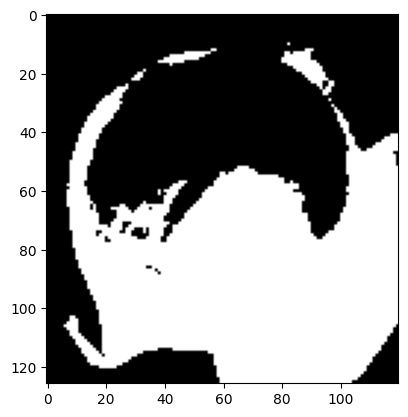

Segment whole object


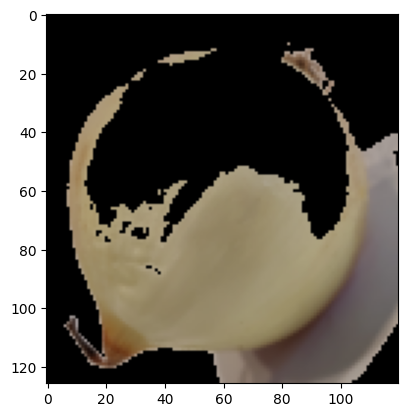

Center:  [[145 131 105]
 [  1   0   0]]
THIS IS Green ############################


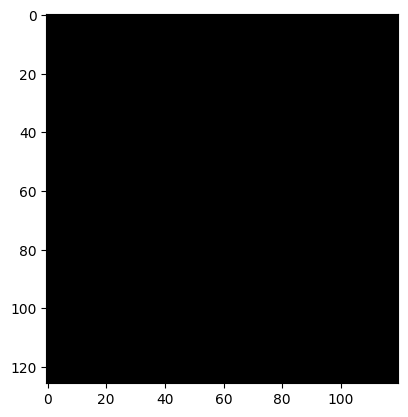

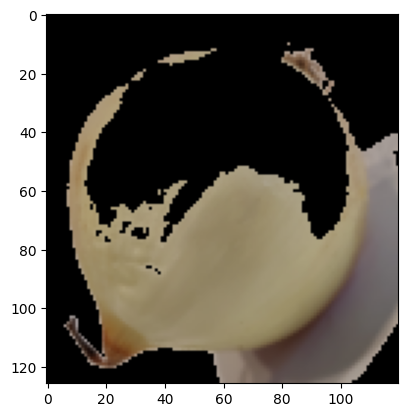

Height: 131. width: 105
BOX IS ROTATED
IN CROP from rect**: width: 131 hight 105
Binary


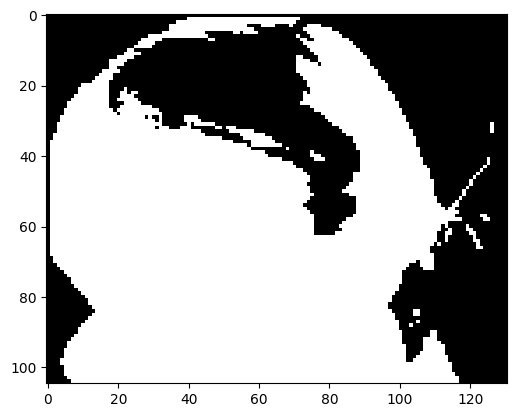

Segment whole object


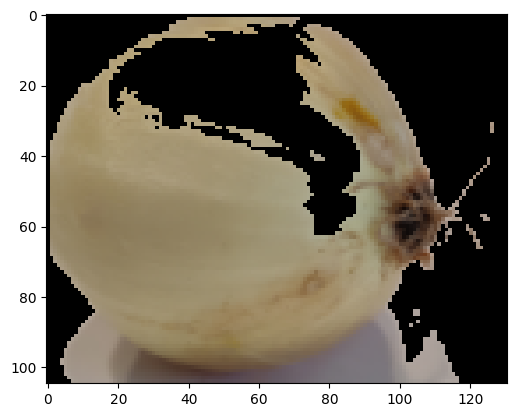

Center:  [[152 137 107]
 [  1   1   1]]
THIS IS Green ############################


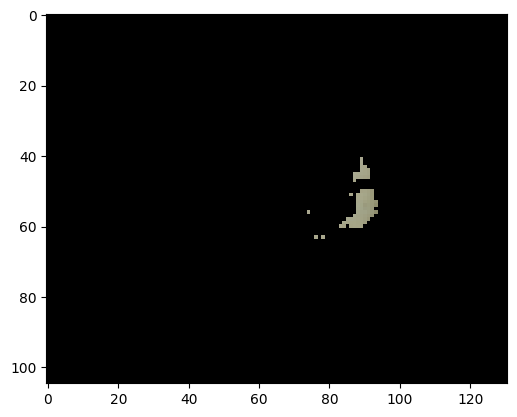

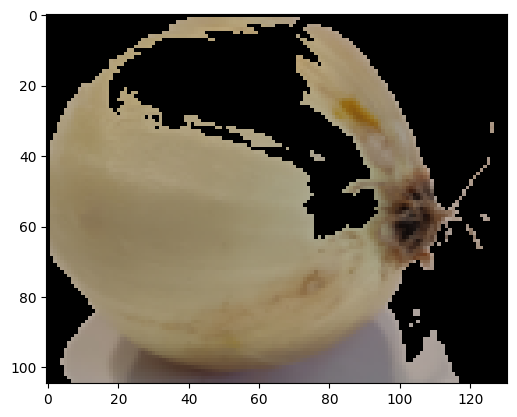

Height: 111. width: 107
BOX IS ROTATED
IN CROP from rect**: width: 108 hight 112
Binary


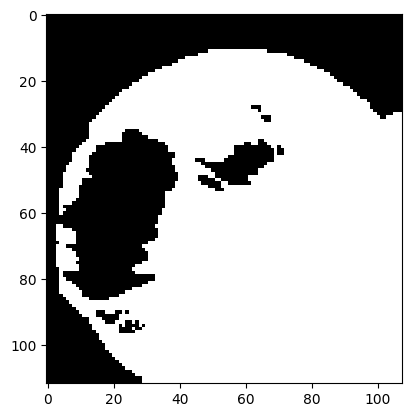

Segment whole object


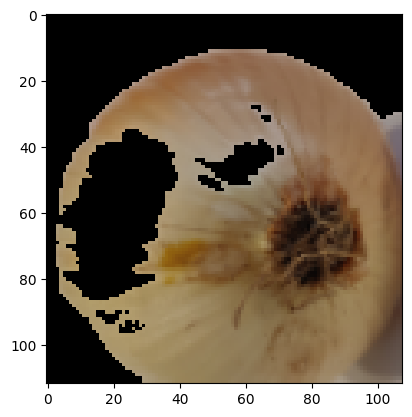

Center:  [[  5   3   1]
 [145 117  84]]
THIS IS Green ############################


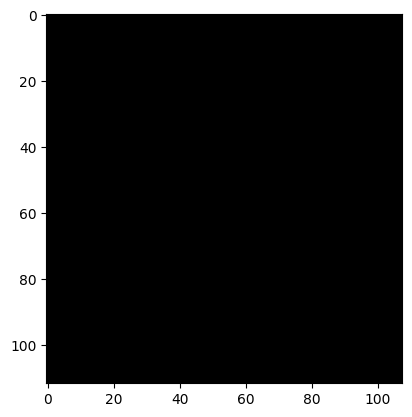

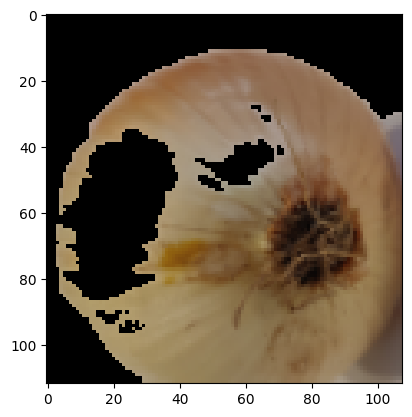

Height: 114. width: 109
BOX IS ROTATED
IN CROP from rect**: width: 114 hight 110
Binary


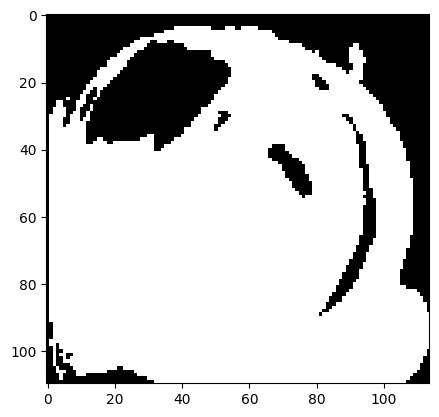

Segment whole object


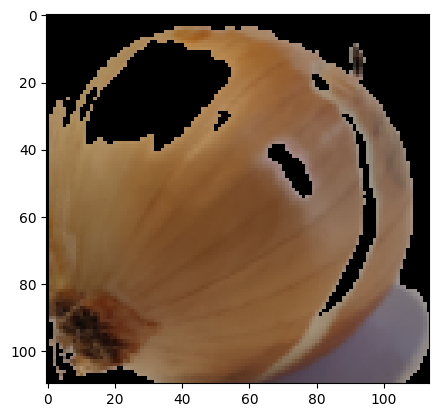

Center:  [[136  99  68]
 [  2   1   0]]
THIS IS Green ############################


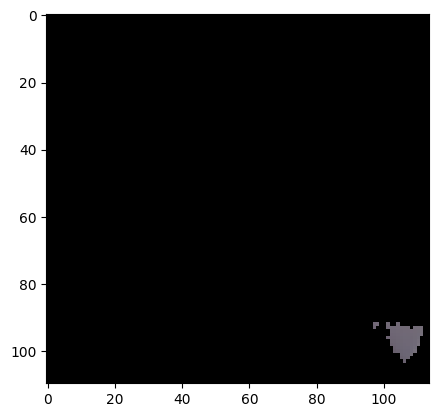

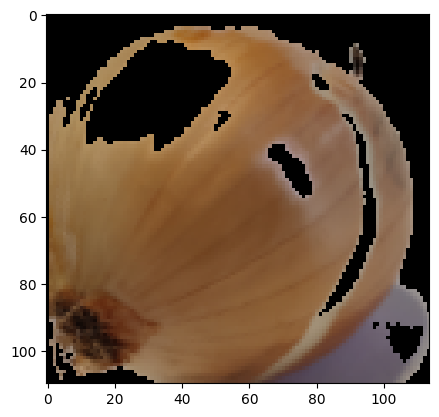

Height: 124. width: 111
BOX IS ROTATED
IN CROP from rect**: width: 111 hight 124
Binary


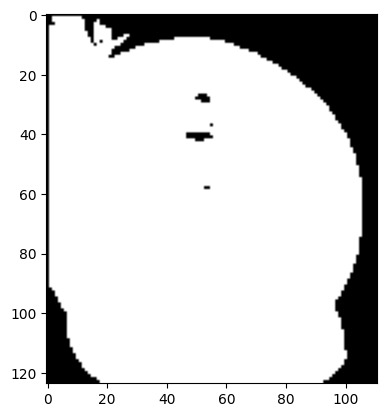

Segment whole object


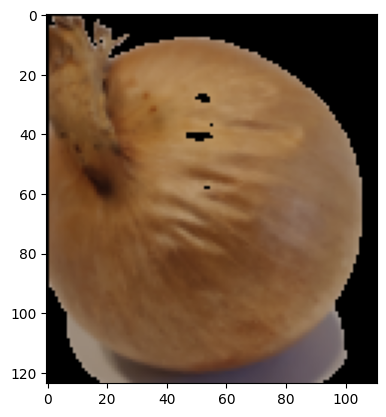

Center:  [[  2   1   1]
 [134  96  62]]
THIS IS Green ############################


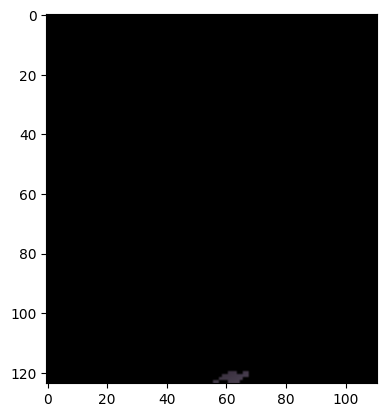

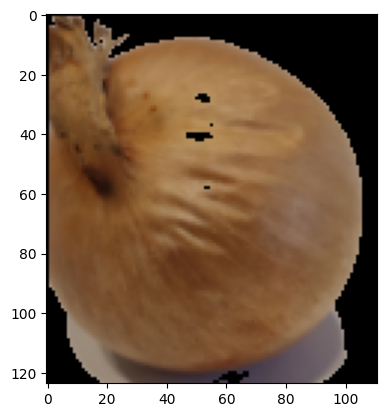

Height: 259. width: 212
BOX IS ROTATED
IN CROP from rect**: width: 212 hight 261
Binary


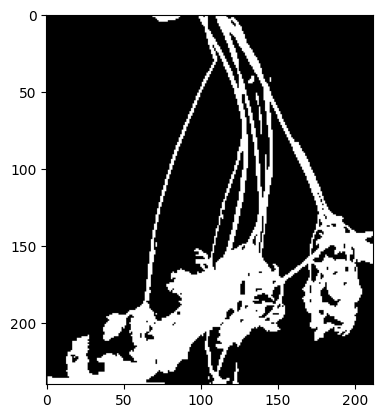

Segment whole object


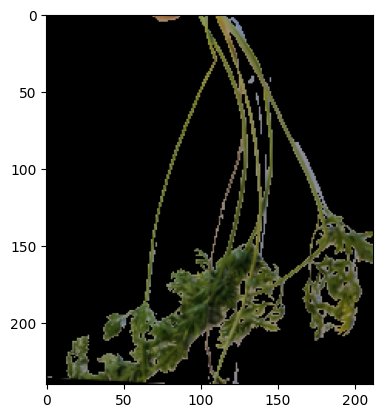

Center:  [[102 107  64]
 [  1   1   0]]
THIS IS Green ############################


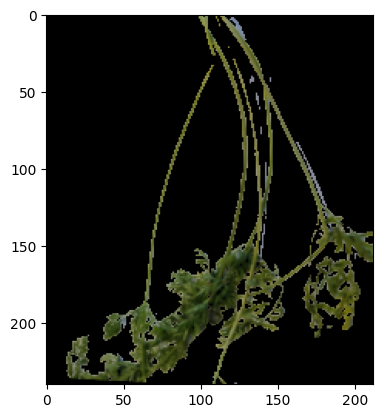

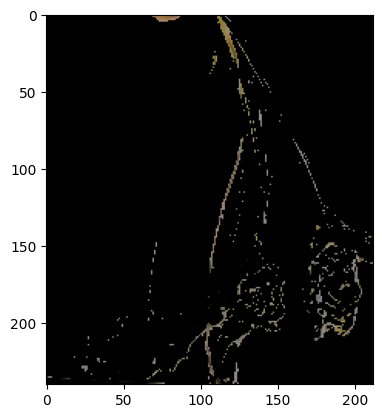

Height: 255. width: 146
BOX IS ROTATED
IN CROP from rect**: width: 146 hight 255
Binary


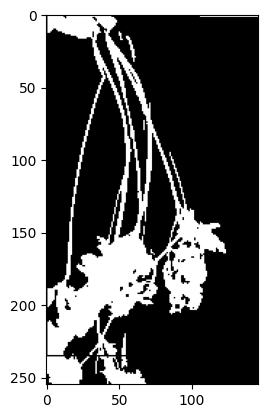

Segment whole object


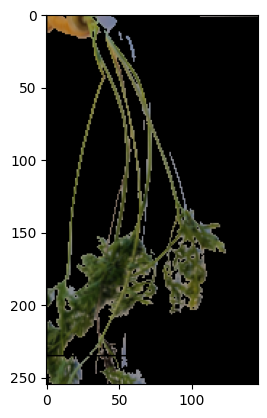

Center:  [[  1   2   0]
 [104 107  71]]
THIS IS Green ############################


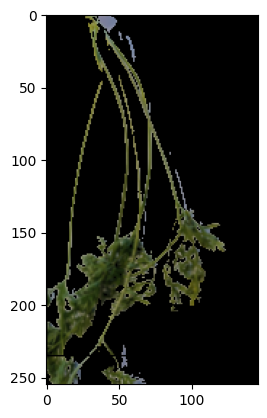

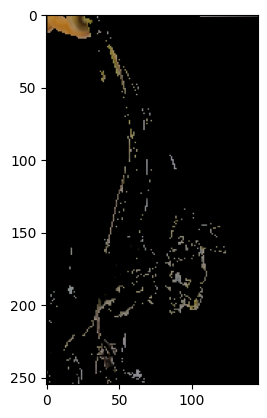

Height: 245. width: 160
CROP DIRECTLY
Binary


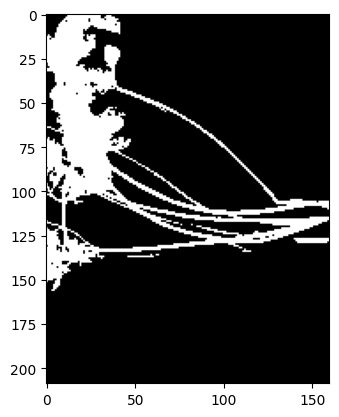

Segment whole object


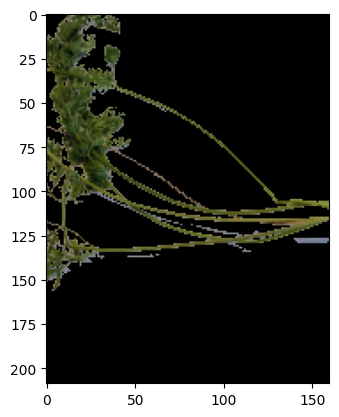

Center:  [[ 0  0  0]
 [91 97 55]]
THIS IS Green ############################


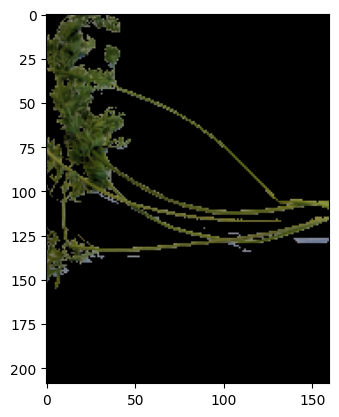

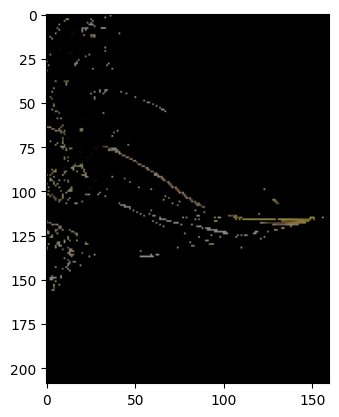

Height: 264. width: 110
BOX IS ROTATED
IN CROP from rect**: width: 264 hight 110
Binary


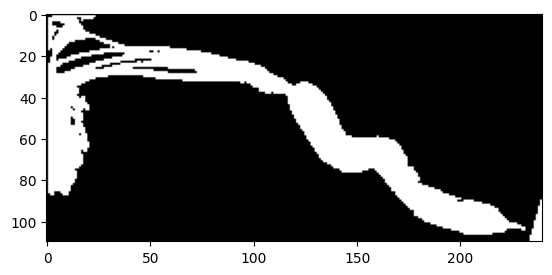

Segment whole object


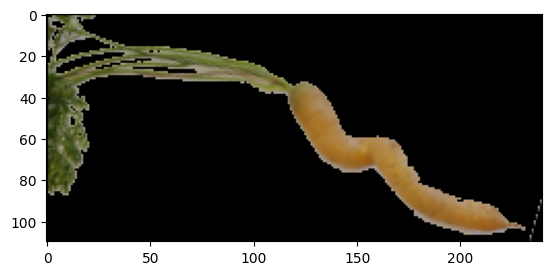

Center:  [[138 120  72]
 [  0   0   0]]
THIS IS Green ############################


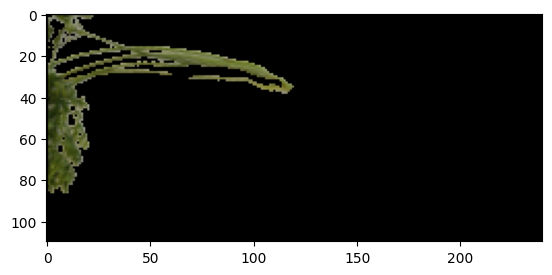

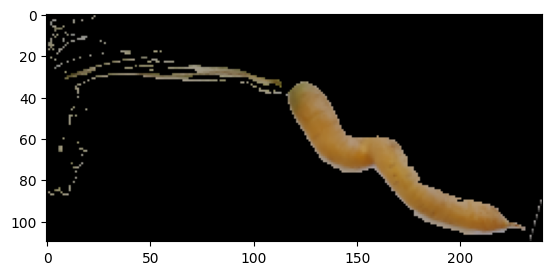

Height: 280. width: 86
BOX IS ROTATED
IN CROP from rect**: width: 87 hight 281
Binary


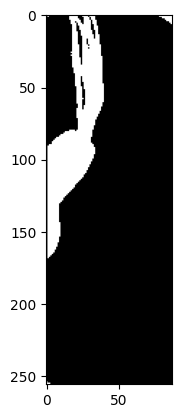

Segment whole object


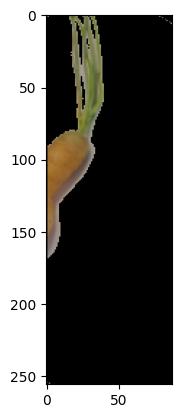

Center:  [[135 119  77]
 [  0   0   0]]
THIS IS Green ############################


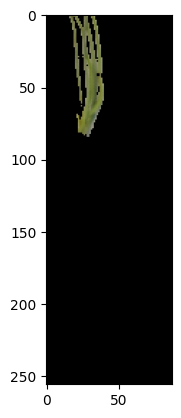

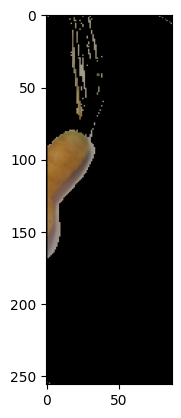

Height: 270. width: 72
BOX IS ROTATED
IN CROP from rect**: width: 72 hight 271
Binary


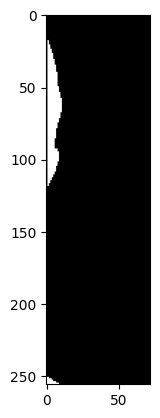

Segment whole object


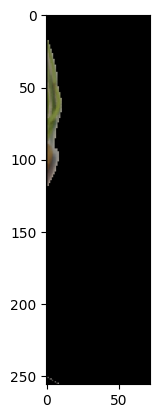

Center:  [[116 117  80]
 [  0   0   0]]
THIS IS Green ############################


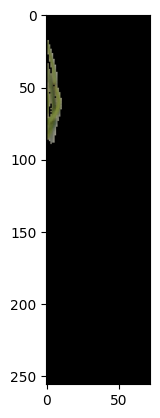

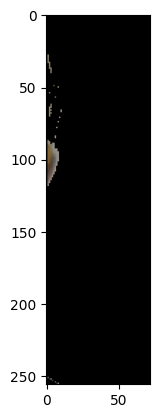

Increase Box Size by 250
Increase Box Size by 250
Height: 259. width: 52
BOX IS ROTATED
IN CROP from rect**: width: 52 hight 260
Binary


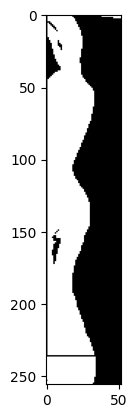

Segment whole object


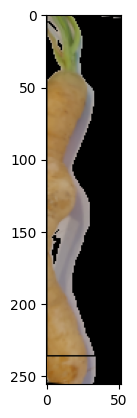

Center:  [[  0   0   0]
 [160 136 100]]
THIS IS Green ############################


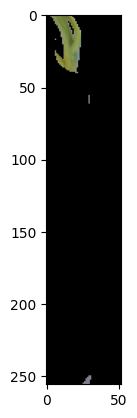

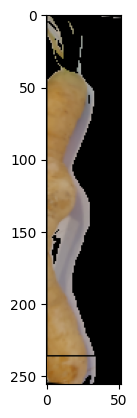

In [12]:
#paths = [f"G:\Meine Ablage\KI_Projekt\Bilder\Zwiebel\zwiebel_{i}.jpg" for i in range(10, 133)]
#paths = [f"G:\Meine Ablage\Images_AI_Project\kartoffel_jpg_2\kartoffel_{i}.jpg" for i in range(40, 50)]

#folders = ["Kartoffel", "Karotte", "Zwiebel", "Karotte_Trieb"]
folders = ["Zwiebel", "Karotte_Trieb"]
#folders = ["Karotte_Trieb"]
paths = []
for fold in folders:
    lower = fold.lower()
    for i in range(11, 18): #87, 91
        paths.append(f"G:\Meine Ablage\KI_Projekt\Bilder\{fold}\{lower}_{i}.jpg")
        
center_points = np.array([0, 0, 0])
for path in paths:
    vegi_BGR = cv2.imread(path.replace("\\","/")) # As BGR
    vegi_sq_BGR_original = resize_to_square(vegi_BGR) # BGR
    #show_image_plt(vegi_sq)
    try:
        vegi_with_box_rgb, more_than_one_box, box, rect = draw_contours(vegi_sq_BGR_original)
        if more_than_one_box:
            box_size = 500
            while more_than_one_box:
                print("Increase Box Size by 250")
                box_size += 250
                vegi_with_box_rgb, more_than_one_box, box, rect = draw_contours(vegi_sq_BGR_original, box_size)

        
        h, w = [int(l) for l in get_size_box(box)]
        print(f"Height: {h}. width: {w}")

        if not is_box_rotated(box):
            #crop img directly
            print("CROP DIRECTLY")
            # the top left corner should be the first element in box array
            cropped_vegi_BGR = vegi_sq_BGR_original[box[0][1]:box[0][1]+h, box[0][0]:box[0][0]+w]
            
        else:
            cropped_vegi_BGR = crop_minAreaRect(vegi_sq_BGR_original, rect, h, w) #BGR
       
        #center_points = np.vstack([center_points, center])
       
        cropped_segmented_binary = segment_img_2(cropped_vegi_BGR)
        print("Binary")
        plt.imshow(cropped_segmented_binary, cmap='gray')
        plt.show()

        print("Segment whole object")
        cropped_vegi_segmented_rgb = color_from_segmented_binary(cropped_segmented_binary, cropped_vegi_BGR) # center has rgb format
        plt.imshow(cropped_vegi_segmented_rgb)
        plt.show()

        center = get_color(cropped_vegi_segmented_rgb) #Center = RGB
        print("Center: ", center)
        
        #lower_thresh=(30, 50, 50), higher_thresh=(160, 255, 255) good default values.
        vegi_only_green_rgb, green_mask = mask_green(cropped_vegi_segmented_rgb, lower_thresh=(28, 20, 20), higher_thresh=(140, 255, 255))
        print("THIS IS Green ############################")
        plt.imshow(vegi_only_green_rgb)
        plt.show()

        # Keep object without
        inverted_green_rgb = keep_object_remove_green(green_mask, cropped_vegi_segmented_rgb)
        plt.imshow(inverted_green_rgb)
        plt.show()

    except Exception as e:
        print(f"###################Could not draw Bounding Box, because contour area was to small. Exact error: {e}")

In [11]:

cropped_vegi_segmented_hsv = cv2.cvtColor(cropped_vegi_segmented_rgb, cv2.COLOR_RGB2HSV)
cv2.imshow("Hsv", cropped_vegi_segmented_hsv)
cv2.waitKey(0)
cv2.destroyAllWindows()
for row in range(80, 82):
    print(f"++++++++++++ ROW {row}")
    for col in range(0, 110):
        print(f"{cropped_vegi_segmented_hsv[row][col]}.  Col {col}")


++++++++++++ ROW 80
[0 0 0].  Col 0
[ 13 131 127].  Col 1
[ 13 134 124].  Col 2
[ 12 137 123].  Col 3
[ 13 141 121].  Col 4
[ 13 149 120].  Col 5
[ 13 159 119].  Col 6
[ 13 165 119].  Col 7
[ 13 164 120].  Col 8
[ 13 162 121].  Col 9
[ 13 162 120].  Col 10
[ 13 163 119].  Col 11
[ 14 162 121].  Col 12
[ 13 164 121].  Col 13
[ 13 165 119].  Col 14
[ 13 166 118].  Col 15
[ 13 164 120].  Col 16
[ 13 166 120].  Col 17
[ 13 169 119].  Col 18
[ 14 174 119].  Col 19
[ 14 176 119].  Col 20
[ 14 182 118].  Col 21
[ 13 181 114].  Col 22
[ 13 179 117].  Col 23
[ 14 177 118].  Col 24
[ 14 171 121].  Col 25
[ 14 164 126].  Col 26
[ 14 160 129].  Col 27
[ 14 159 128].  Col 28
[ 14 163 122].  Col 29
[ 14 156 124].  Col 30
[ 14 145 132].  Col 31
[ 14 148 131].  Col 32
[ 14 157 127].  Col 33
[ 13 179 111].  Col 34
[ 13 176 113].  Col 35
[ 13 169 115].  Col 36
[ 14 165 124].  Col 37
[ 13 168 117].  Col 38
[ 13 171 115].  Col 39
[ 12 175 111].  Col 40
[ 11 177  98].  Col 41
[ 11 181  96].  Col 42
[ 12 17

In [109]:
cropped_segmented_binary = segment_img_2(carrot_trieb_sq)
center = color_from_segmented_binary(cropped_segmented_binary)
center

IndexError: boolean index did not match indexed array along dimension 0; dimension is 65 but corresponding boolean dimension is 256

In [146]:
file_path = "G:\Meine Ablage\KI_Projekt\center_points\center_array.npy"
# Save the array to a binary file
np.save(file_path.replace("\\","/"), reshaped_array_final)

In [147]:
file_path = "G:\Meine Ablage\KI_Projekt\center_points\center_array.npy"
loaded_array = np.load(file_path.replace("\\","/"))